In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# Funções de suporte




In [ ]:
def check_stationarity(series: pd.Series, seasonal_period: int = None, alpha: float = 0.05):
    """
    Check stationarity of a time series using the Augmented Dickey-Fuller test.
    Optionally handle seasonal differencing.

    Parameters:
        series (pd.Series): The input time series.
        seasonal_period (int, optional): Seasonal period (e.g., 12 for monthly).
        alpha (float): Significance level for ADF test.

    Returns:
        dict: {
            'adf_stat': float,
            'p_value': float,
            'stationary': bool,
            'diffs_needed': int,
            'seasonal_diffs_needed': int
        }
    """
    def is_stationary(y):
        result = adfuller(y, autolag='AIC')
        return result[0], result[1], result[1] < alpha

    y = series.dropna()
    if isinstance(series, pd.DataFrame):
        y = series.iloc[:, 0]

    # Check original series
    adf_stat, p_val, stationary = is_stationary(y)
    if stationary:
        return {
            'adf_stat': adf_stat,
            'p_value': p_val,
            'stationary': True,
            'diffs_needed': 0,
            'seasonal_diffs_needed': 0
        }

    # Seasonal differencing
    seasonal_diffs = 0
    if seasonal_period:
        for s in range(1, 3):  # try 1 or 2 seasonal diffs
            y_seasonal = y.diff(seasonal_period * s).dropna()
            adf_stat, p_val, stationary = is_stationary(y_seasonal)
            if stationary:
                return {
                    'adf_stat': adf_stat,
                    'p_value': p_val,
                    'stationary': True,
                    'diffs_needed': 0,
                    'seasonal_diffs_needed': s
                }

    # Try both seasonal + regular differencing
    if seasonal_period:
        y_combo = y.copy()
        for s in range(1, 3):
            for d in range(1, 3):
                y_combo = y.diff(seasonal_period * s).dropna().diff(d).dropna()
                adf_stat, p_val, stationary = is_stationary(y_combo)
                if stationary:
                    return {
                        'adf_stat': adf_stat,
                        'p_value': p_val,
                        'stationary': True,
                        'diffs_needed': d,
                        'seasonal_diffs_needed': s
                    }

    # Regular differencing
    diffs = 0
    y_diff = y.copy()
    while diffs < 3:
        y_diff = y_diff.diff().dropna()
        adf_stat, p_val, stationary = is_stationary(y_diff)
        diffs += 1
        if stationary:
            return {
                'adf_stat': adf_stat,
                'p_value': p_val,
                'stationary': True,
                'diffs_needed': diffs,
                'seasonal_diffs_needed': 0
            }


    # If nothing worked
    return {
        'adf_stat': adf_stat,
        'p_value': p_val,
        'stationary': False,
        'diffs_needed': diffs,
        'seasonal_diffs_needed': seasonal_diffs
    }


In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from multiprocessing import Pool, cpu_count
from typing import Union
from tqdm.notebook import tqdm

# Define your function to run in parallel
def fit_sarima(args):
    endog, order, d, D, s, seasonal = args
    try:
          model = SARIMAX(
              endog,
              order=(order[0], d, order[1]),
              seasonal_order=(order[2], D, order[3], s),
              simple_differencing=False
          ).fit(disp=False)
          return (order, model.aic)
    except:
        return None

def optimize_SARIMA_parallel(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    args_list = [(endog, order, d, D, s) for order in order_list]
    print(cpu_count())
    with Pool(cpu_count()) as pool:
        results = list(tqdm(pool.imap(fit_sarima, args_list), total=len(order_list)))

    # Filter out failed attempts (None)
    results = [res for res in results if res is not None]

    result_df = pd.DataFrame(results, columns=['(p,q,P,Q)', 'AIC'])
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd
import numpy as np

def check_white_noise(residuals: pd.Series, lags: int = 20, alpha: float = 0.05):
    """
    Check if residuals and squared residuals are white noise using the Ljung-Box test.

    Parameters:
        residuals (pd.Series): Residuals from a model.
        lags (int): Number of lags to test.
        alpha (float): Significance level.

    Returns:
        dict: {
            'residuals': {
                'p_values': pd.Series,
                'lags_failed': int
            },
            'squared_residuals': {
                'p_values': pd.Series,
                'lags_failed': int
            }
        }
    """
    # Drop NaNs just in case
    residuals = pd.Series(residuals).dropna()
    squared_residuals = residuals**2

    # Ljung-Box on residuals
    lb_resid = acorr_ljungbox(residuals, lags=lags, return_df=True)
    resid_pvals = lb_resid['lb_pvalue']
    resid_failed = (resid_pvals < alpha).sum()

    # Ljung-Box on squared residuals
    lb_sq = acorr_ljungbox(squared_residuals, lags=lags, return_df=True)
    sq_pvals = lb_sq['lb_pvalue']
    sq_failed = (sq_pvals < alpha).sum()

    return {
        'residuals': {
            'p_values': resid_pvals,
            'lags_failed': resid_failed
        },
        'squared_residuals': {
            'p_values': sq_pvals,
            'lags_failed': sq_failed
        }
    }


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_model_mape(test_df, actual_col, pred_cols, title="Model Comparison (MAPE %)"):
    """
    Plots a bar chart of MAPE for each prediction column.

    Parameters:
        test_df (pd.DataFrame): The dataframe containing actual and predicted values.
        actual_col (str): Column name with actual values.
        pred_cols (list of str): Column names with predicted values.
        title (str): Title of the plot.
    """
    mape_scores = [mape(test_df[actual_col], test_df[col]) for col in pred_cols]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(pred_cols, mape_scores, width=0.6,  edgecolor='black')
    ax.set_xlabel('Models')
    ax.set_ylabel('MAPE (%)')
    ax.set_ylim(0, max(mape_scores) * 1.2)
    ax.set_title(title)
    plt.xticks(rotation=35)

    for i, val in enumerate(mape_scores):
        ax.text(i, val + 0.5, f"{val:.3f}", ha='center')

    plt.tight_layout()
    plt.show()

    return dict(zip(pred_cols, mape_scores))


In [ ]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_model_rmse(test_df, actual_col, pred_cols, title="Model Comparison (RMSE)"):
    """
    Plots a bar chart of RMSE for each prediction column.

    Parameters:
        test_df (pd.DataFrame): The dataframe containing actual and predicted values.
        actual_col (str): Column name with actual values.
        pred_cols (list of str): Column names with predicted values.
        title (str): Title of the plot.
    """
    rmse_scores = [rmse(test_df[actual_col], test_df[col]) for col in pred_cols]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(pred_cols, rmse_scores, width=0.6, color='lightcoral', edgecolor='black')
    ax.set_xlabel('Models')
    ax.set_ylabel('RMSE')
    ax.set_ylim(0, max(rmse_scores) * 1.2)
    ax.set_title(title)
    plt.xticks(rotation=35)

    for i, val in enumerate(rmse_scores):
        ax.text(i, val + max(rmse_scores) * 0.03, f"{val:.4f}", ha='center')

    plt.tight_layout()
    plt.show()

    return dict(zip(pred_cols, rmse_scores))


# SELEÇÃO DE MODELO


## Carregamento e visualização inicial da série

In [ ]:
df = pd.read_excel('/content/DadosCompeticao.xlsx', decimal=',')
serie_1 = df.iloc[:, 0]
serie_1.head()

,#1
0,0.231539
1,0.180341
2,0.327207
3,0.369216
4,0.385625


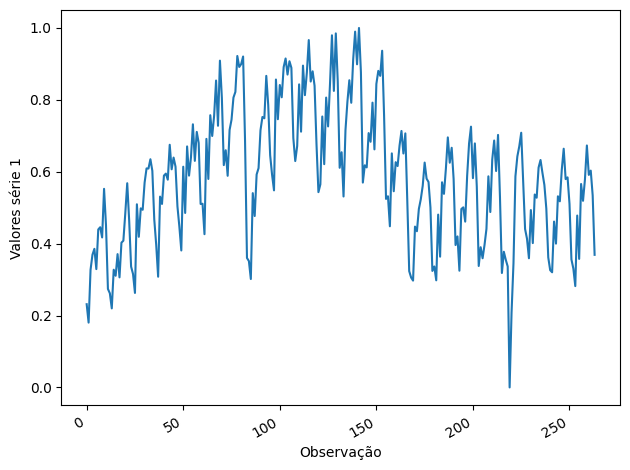

In [ ]:
fig, ax = plt.subplots()

ax.plot(serie_1)
ax.set_xlabel('Observação')
ax.set_ylabel('Valores série 1')

fig.autofmt_xdate()
plt.tight_layout()


## Busca por sinais de sazonalidade

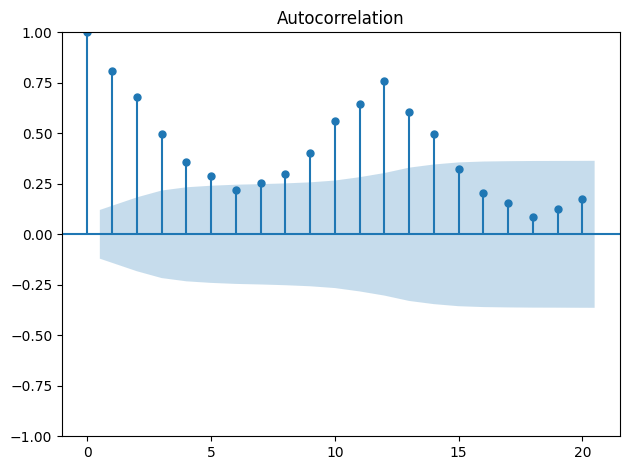

In [ ]:
plot_acf(serie_1, lags=20);
plt.tight_layout()

In [ ]:
advanced_decomposition = STL(serie_1,period=12).fit()

## Conjunto de treino

In [ ]:
test = pd.DataFrame()
test["Values"] = serie_1.iloc[-12:]
test['naive_seasonal'] = serie_1.iloc[-24:-12].values
test['naive_seasonal-A'] = serie_1.iloc[-24:-12].mean()

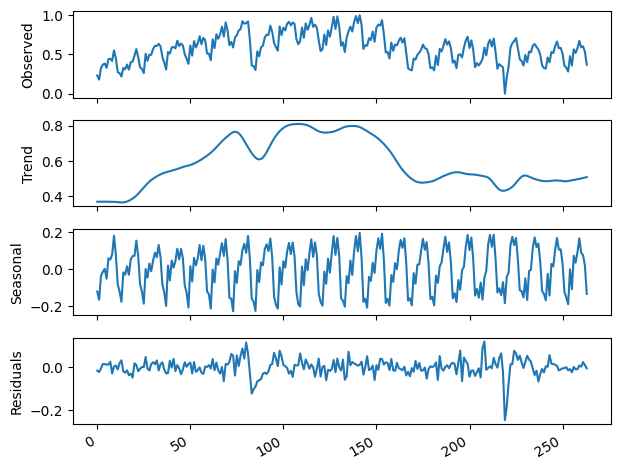

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

## SARIMA

In [ ]:
check_stationarity(serie_1,seasonal_period=12)

{'adf_stat': np.float64(-2.9326959369334906),
 'p_value': np.float64(0.041675878715294476),
 'stationary': True,
 'diffs_needed': 0,
 'seasonal_diffs_needed': 1}

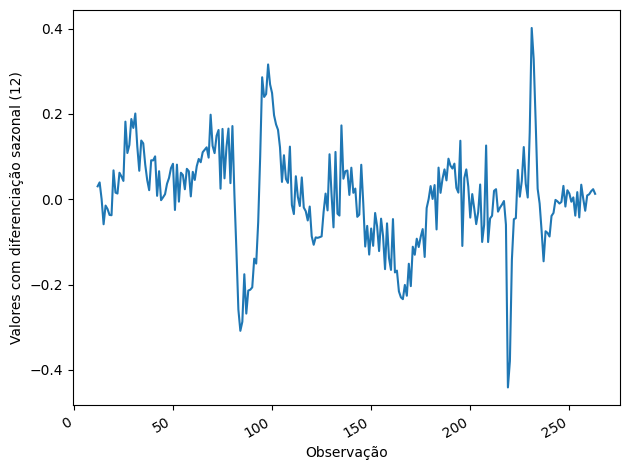

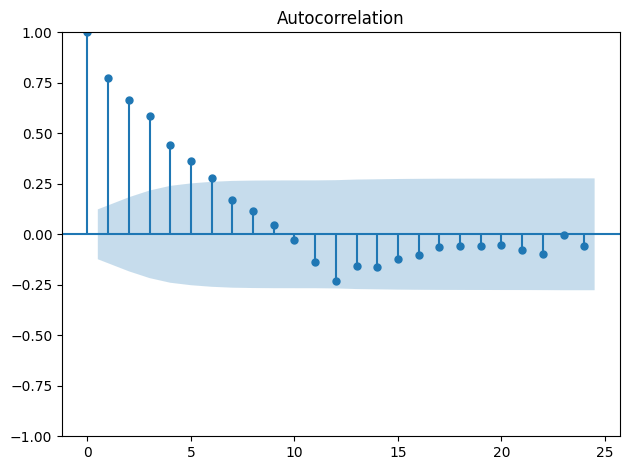

In [ ]:
seasonal_diff = serie_1.diff(12).dropna()
fig, ax = plt.subplots()

ax.plot(seasonal_diff)
ax.set_xlabel('Observação')
ax.set_ylabel('Valores com diferenciação sazonal (12)')

fig.autofmt_xdate()
plt.tight_layout()
plot_acf(seasonal_diff, lags=24);
plt.tight_layout()

### Treinamento


```
 from itertools import product

 ps = range(0, 5)
 qs = range(0, 5)
 Ps = range(0, 5)
 Qs = range(0, 5)

 SARIMA_order_list = list(product(ps, qs, Ps, Qs))

 train = serie_1[:-12]

 d = 1
 D = 0
 s = 12

 SARIMA_result_df = optimize_SARIMA_parallel(train, SARIMA_order_list, d, D, s)
 SARIMA_result_df
 */

```
Modelos selecionados:  \\

* ARIMA(12,1,12) | AIC = -652.087677 \\
* SARIMA(1,0,1)(5,1,1,12) | AIC = -694.004658


In [ ]:
train = serie_1[:-12]
# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)

ARIMA_model = SARIMAX(train_transformed, order=(12,1,9), seasonal_order=(0,0,0,12), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)


SARIMA_model = SARIMAX(train_transformed, order=(3,0,1), seasonal_order=(4,1,1,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

In [ ]:
forecast_ARIMA = ARIMA_model_fit.forecast(steps=12)
test['ARIMA_pred'] = pt.inverse_transform(forecast_ARIMA.values.reshape(-1, 1)).flatten()
forecast_SARIMA = SARIMA_model_fit.forecast(steps=12)
test['SARIMA_pred'] = pt.inverse_transform(forecast_SARIMA.values.reshape(-1, 1)).flatten()


In [ ]:
test

,Values,naive_seasonal,naive_seasonal-A,ARIMA_pred,SARIMA_pred
252,0.330653,0.326223,0.488171,0.361628,0.359720
253,0.281917,0.320315,0.488171,0.316845,0.307572
254,0.478175,0.461437,0.488171,0.404822,0.451761
255,0.357565,0.400066,0.488171,0.339930,0.369279
256,0.565967,0.531835,0.488171,0.457317,0.443884
257,0.519199,0.517722,0.488171,0.471414,0.515678
258,0.578602,0.605514,0.488171,0.576987,0.619529
259,0.673121,0.664096,0.488171,0.637361,0.675427
260,0.591237,0.579586,0.488171,0.585911,0.586969
261,0.603216,0.584345,0.488171,0.581543,0.636306


### Análise de resíduos

In [ ]:
check_white_noise(ARIMA_model_fit.resid, lags = 24)

{'residuals': {'p_values': 1     0.920313
  2     0.613932
  3     0.590582
  4     0.735217
  5     0.751610
  6     0.846694
  7     0.904326
  8     0.924438
  9     0.957246
  10    0.964756
  11    0.953253
  12    0.950025
  13    0.958650
  14    0.940562
  15    0.923199
  16    0.943748
  17    0.933261
  18    0.947551
  19    0.956842
  20    0.963984
  21    0.974114
  22    0.967760
  23    0.971306
  24    0.972873
  Name: lb_pvalue, dtype: float64,
  'lags_failed': np.int64(0)},
 'squared_residuals': {'p_values': 1     0.347488
  2     0.483144
  3     0.001450
  4     0.003796
  5     0.008420
  6     0.016604
  7     0.027298
  8     0.039240
  9     0.060849
  10    0.089274
  11    0.117994
  12    0.155124
  13    0.195701
  14    0.245128
  15    0.301963
  16    0.366670
  17    0.392204
  18    0.449520
  19    0.491548
  20    0.535659
  21    0.595286
  22    0.653504
  23    0.699277
  24    0.750019
  Name: lb_pvalue, dtype: float64,
  'lags_failed': np.int64

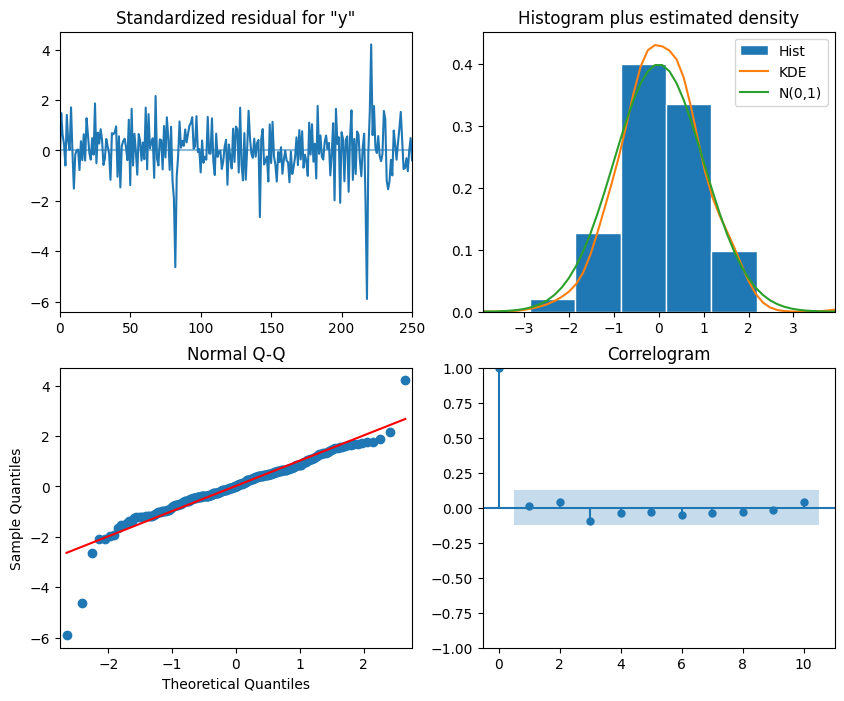

In [ ]:
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [ ]:
check_white_noise(SARIMA_model_fit.resid, lags = 12)

{'residuals': {'p_values': 1     7.109690e-25
  2     2.154221e-43
  3     5.785620e-57
  4     7.764206e-66
  5     4.996211e-72
  6     8.911760e-77
  7     9.904113e-79
  8     4.940065e-79
  9     3.001115e-79
  10    1.395570e-78
  11    8.709640e-78
  12    5.348615e-77
  Name: lb_pvalue, dtype: float64,
  'lags_failed': np.int64(12)},
 'squared_residuals': {'p_values': 1      3.938451e-42
  2      1.469659e-70
  3      1.536946e-91
  4     1.749826e-104
  5     2.035849e-112
  6     2.374023e-117
  7     1.442599e-119
  8     1.575564e-119
  9     7.536331e-119
  10    5.737093e-118
  11    4.468063e-117
  12    3.267472e-116
  Name: lb_pvalue, dtype: float64,
  'lags_failed': np.int64(12)}}

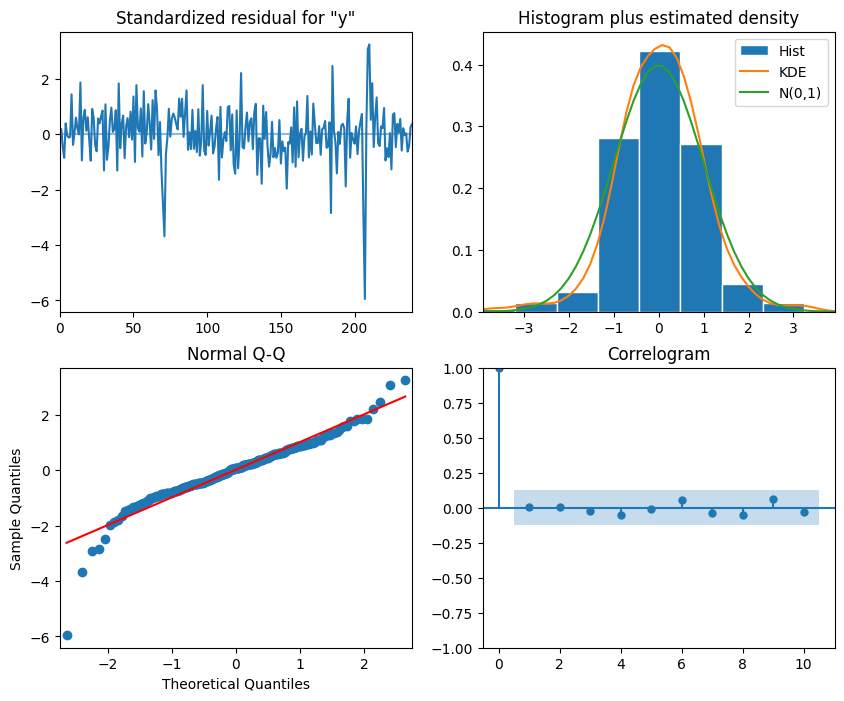

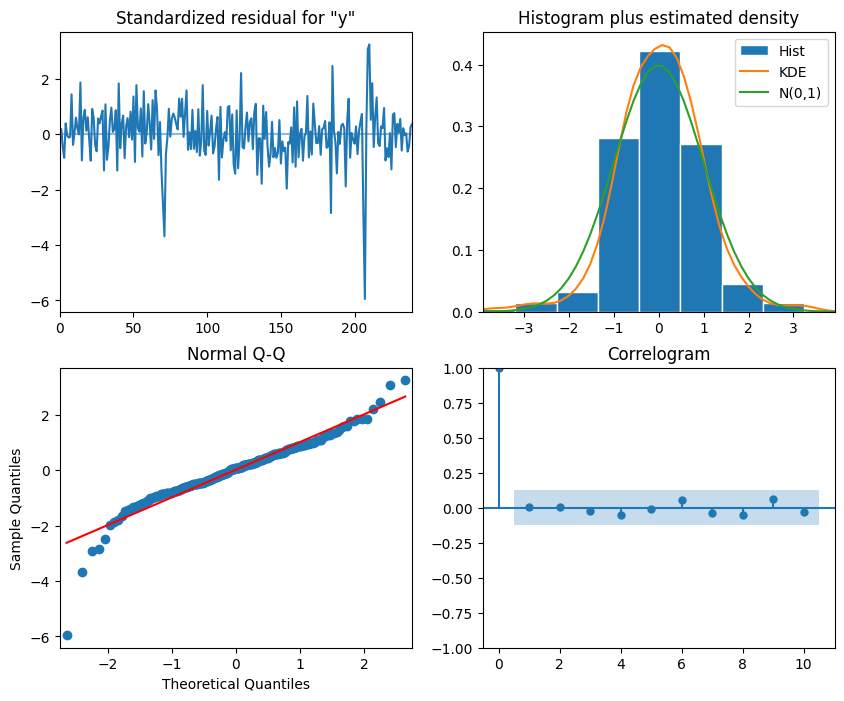

In [ ]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

## Holt-Winters

### Treinamento

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import PowerTransformer
import pandas as pd
import numpy as np

train = serie_1[:-12]
train_hw = train.diff(12).dropna()
ES = ExponentialSmoothing(train_hw, seasonal_periods=12)
ES_fit = ES.fit()
forecast_1 = ES_fit.forecast(12)
seasonal_base = train.iloc[-12:].values
ES_forecast = seasonal_base + forecast_1.values

ES3 = ExponentialSmoothing(train, trend='add' ,seasonal_periods=12)
ES3_fit = ES3.fit()

test["HW"] = ES_forecast
test["HW_P"] = ES3_fit.forecast(12).values
test


,Values,naive_seasonal,naive_seasonal-A,ARIMA_pred,SARIMA_pred,HW,HW_P
252,0.330653,0.326223,0.488171,0.361628,0.359720,0.326020,0.379637
253,0.281917,0.320315,0.488171,0.316845,0.307572,0.320112,0.380238
254,0.478175,0.461437,0.488171,0.404822,0.451761,0.461234,0.380838
255,0.357565,0.400066,0.488171,0.339930,0.369279,0.399863,0.381439
256,0.565967,0.531835,0.488171,0.457317,0.443884,0.531632,0.382040
257,0.519199,0.517722,0.488171,0.471414,0.515678,0.517519,0.382640
258,0.578602,0.605514,0.488171,0.576987,0.619529,0.605311,0.383241
259,0.673121,0.664096,0.488171,0.637361,0.675427,0.663893,0.383841
260,0.591237,0.579586,0.488171,0.585911,0.586969,0.579383,0.384442
261,0.603216,0.584345,0.488171,0.581543,0.636306,0.584142,0.385042


In [ ]:
print("Residuos 1:" + str(check_white_noise(ES_fit.resid)))

Residuos 1:{'residuals': {'p_values': 1     8.894792e-01
2     7.158036e-01
3     3.279522e-01
4     1.636588e-01
5     2.450858e-01
6     3.341497e-01
7     1.705573e-01
8     2.419513e-01
9     3.018739e-01
10    3.332649e-01
11    1.514220e-01
12    9.432028e-08
13    1.632408e-07
14    1.927199e-07
15    4.066279e-07
16    8.206768e-07
17    8.706327e-07
18    1.531314e-06
19    2.884311e-06
20    3.616342e-06
Name: lb_pvalue, dtype: float64, 'lags_failed': np.int64(9)}, 'squared_residuals': {'p_values': 1     4.991119e-02
2     5.265373e-03
3     1.367251e-03
4     3.448704e-03
5     7.553496e-03
6     1.217767e-02
7     1.954972e-02
8     2.681022e-02
9     4.370998e-02
10    1.654087e-02
11    5.798062e-03
12    3.537481e-08
13    2.018128e-08
14    3.854336e-08
15    3.813335e-08
16    7.920235e-08
17    1.103078e-07
18    1.666089e-07
19    2.573867e-07
20    2.400385e-07
Name: lb_pvalue, dtype: float64, 'lags_failed': np.int64(20)}}


In [ ]:
ES_fit.summary()

Dep. Variable:,#1,No. Observations:,240
Model:,ExponentialSmoothing,SSE,1.404
Optimized:,True,AIC,-1229.892
Trend:,None,BIC,-1222.931
Seasonal:,None,AICC,-1229.722
Seasonal Periods:,None,Date:,"Tue, 29 Apr 2025"
Box-Cox:,False,Time:,17:23:48
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7104104,alpha,True
initial_level,0.0286225,l.0,True


In [ ]:
from statsmodels.tsa.forecasting.theta import ThetaModel

# Fit the Theta model
theta_model = ThetaModel(train.diff(12).dropna(),period=12)
theta_fit = theta_model.fit()

# Forecast future values
theta_forecast = theta_fit.forecast(steps=12)
seasonal_base = train.iloc[-12:].values
test["Theta"] = seasonal_base + theta_forecast.values
# Print results
print(theta_fit.summary())
print("Forecast:", theta_forecast)

                              ThetaModel Results                              
Dep. Variable:                     #1   No. Observations:                  240
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Tue, 29 Apr 2025   Deseas. Method:               Additive
Time:                        17:23:48   Period:                             12
Sample:                             0                                         
                                  240                                         
     Parameter Estimates     
             Parameters      
-----------------------------
b0    -0.00042428333840394345
alpha       0.710502658193135
-----------------------------
Forecast: 252   -0.001283
253    0.000187
254    0.001772
255   -0.000607
256    0.002934
257    0.005531
258    0.002799
259    0.003795
260    0.003420
261   -0.005725
262   -0.004227
263   -0.002287
Name: forecast, dtype: float64


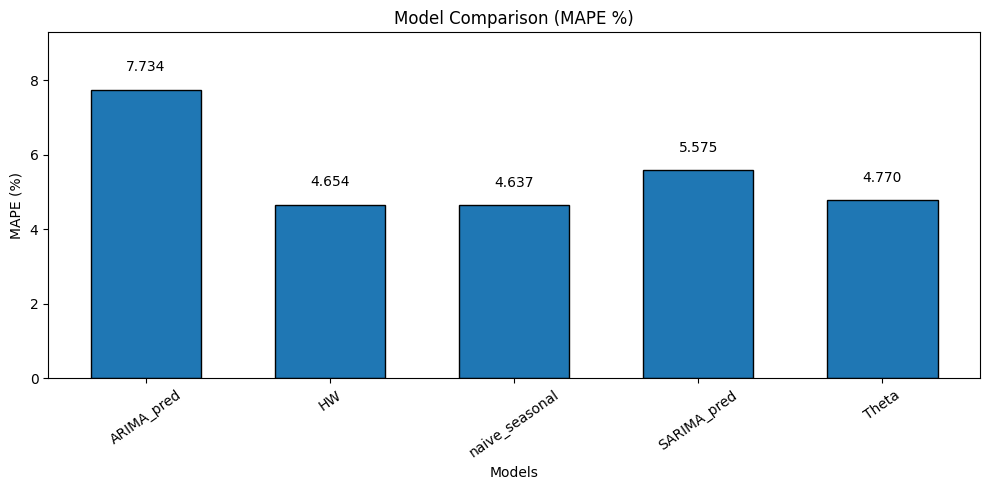

{'ARIMA_pred': np.float64(7.734078043616624),
 'HW': np.float64(4.654185126593989),
 'naive_seasonal': np.float64(4.637008542657429),
 'SARIMA_pred': np.float64(5.575023152834374),
 'Theta': np.float64(4.769788436733621)}

In [ ]:
test['naive_seasonal'] = serie_1.iloc[-24:-12].values
columns = ['ARIMA_pred','HW','naive_seasonal','SARIMA_pred','Theta']
plot_model_mape(test,'Values',columns)

In [ ]:
test

,Values,naive_seasonal,naive_seasonal-A,ARIMA_pred,SARIMA_pred,HW,HW_P,Theta
252,0.330653,0.326223,0.488171,0.361628,0.359720,0.326020,0.379637,0.324939
253,0.281917,0.320315,0.488171,0.316845,0.307572,0.320112,0.380238,0.320502
254,0.478175,0.461437,0.488171,0.404822,0.451761,0.461234,0.380838,0.463209
255,0.357565,0.400066,0.488171,0.339930,0.369279,0.399863,0.381439,0.399459
256,0.565967,0.531835,0.488171,0.457317,0.443884,0.531632,0.382040,0.534769
257,0.519199,0.517722,0.488171,0.471414,0.515678,0.517519,0.382640,0.523253
258,0.578602,0.605514,0.488171,0.576987,0.619529,0.605311,0.383241,0.608313
259,0.673121,0.664096,0.488171,0.637361,0.675427,0.663893,0.383841,0.667891
260,0.591237,0.579586,0.488171,0.585911,0.586969,0.579383,0.384442,0.583007
261,0.603216,0.584345,0.488171,0.581543,0.636306,0.584142,0.385042,0.578621


## Visualização das predições


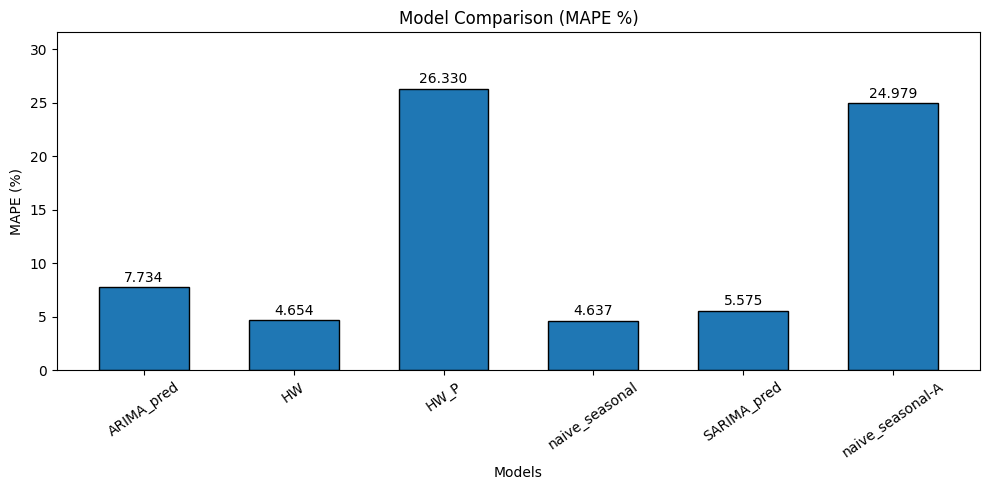

{'ARIMA_pred': np.float64(7.734078043616624),
 'HW': np.float64(4.654185126593989),
 'HW_P': np.float64(26.32980810741308),
 'naive_seasonal': np.float64(4.637008542657429),
 'SARIMA_pred': np.float64(5.575023152834374),
 'naive_seasonal-A': np.float64(24.978804387789896)}

In [ ]:
columns = ['ARIMA_pred','HW','HW_P','naive_seasonal','SARIMA_pred','naive_seasonal-A']
plot_model_mape(test,'Values',columns)

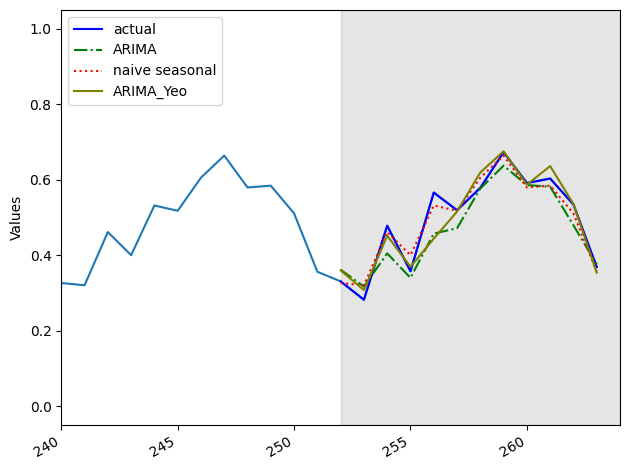

In [ ]:
fig, ax = plt.subplots()

ax.plot(serie_1)
ax.plot(test["Values"], 'b-', label='actual')
ax.plot(test['ARIMA_pred'], 'g-.', label='ARIMA')
#ax.plot(test['HW'], 'cyan', label='ES')
#ax.plot(test['Theta'], 'black', label='Theta')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['SARIMA_pred'], 'olive', label='ARIMA_Yeo')
#ax.plot(test['HW_P'], 'tan', label='ES-Y')
#ax.plot(test['naive_seasonal-A'] , 'red', label='Mean')

ax.set_ylabel('Values')
ax.axvspan(252, 264, color='#808080', alpha=0.2)

ax.legend(loc=2)

ax.set_xlim(240, 264)

fig.autofmt_xdate()
plt.tight_layout()

## Métricas finais

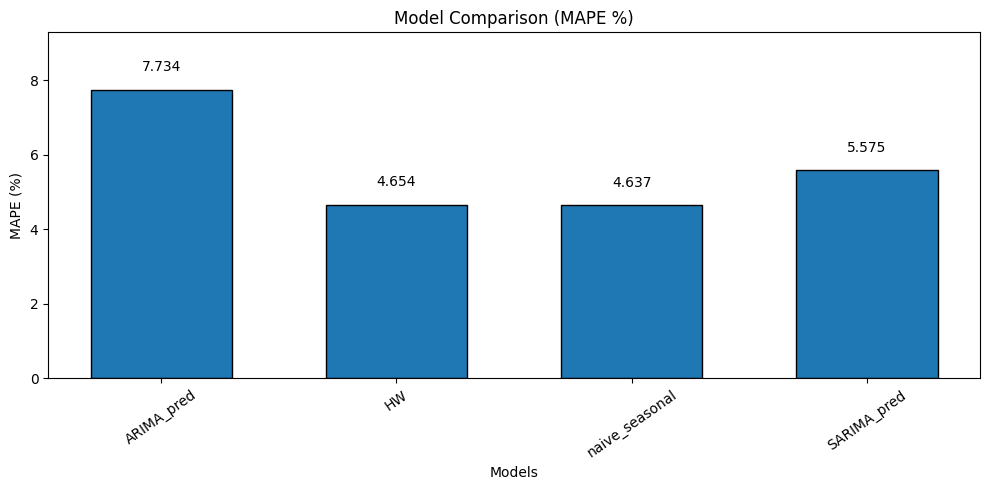

{'ARIMA_pred': np.float64(7.734078043616624),
 'HW': np.float64(4.654185126593989),
 'naive_seasonal': np.float64(4.637008542657429),
 'SARIMA_pred': np.float64(5.575023152834374)}

In [ ]:
columns = ['ARIMA_pred','HW','naive_seasonal','SARIMA_pred']
plot_model_mape(test,'Values',columns)

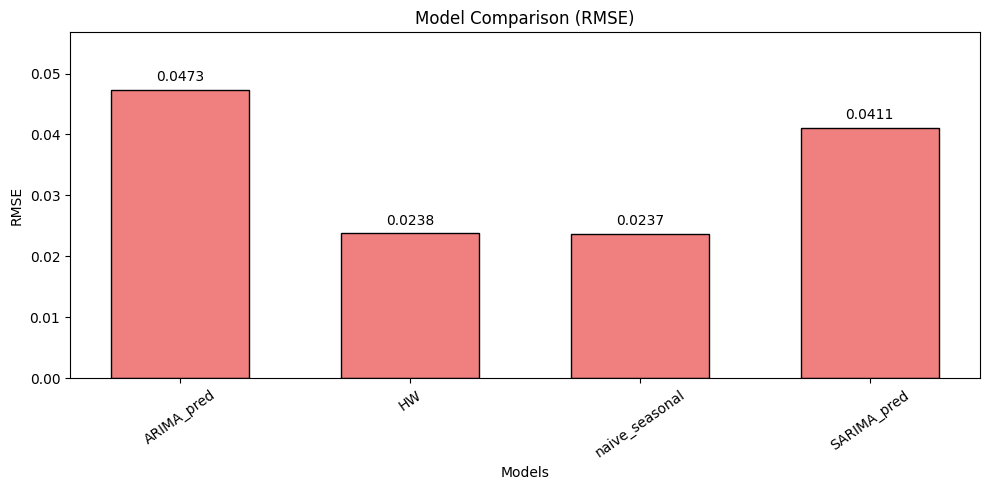

In [ ]:
columns_to_plot = ['ARIMA_pred','HW','naive_seasonal','SARIMA_pred']

rmse_results = plot_model_rmse(test, 'Values', columns_to_plot)

# Previsão para a série (próximos 12 meses)

In [ ]:
train_hw = serie_1.diff(12).dropna()
ES = ExponentialSmoothing(train_hw, seasonal_periods=12)
ES_fit = ES.fit()
forecast_1 = ES_fit.forecast(12)
seasonal_base = serie_1.iloc[-12:].values
ES_forecast = seasonal_base + forecast_1.values

ES_forecast

array([0.34596566, 0.2972292 , 0.49348782, 0.37287738, 0.58127909,
       0.53451178, 0.59391447, 0.68843367, 0.60654985, 0.61852884,
       0.54977269, 0.38419999])

In [ ]:
# ----- Salvando previsões numeradas em um .txt -----
horizon = len(ES_forecast)
with open("forecast_HW.txt", "w") as f:
    for i, value in enumerate(ES_forecast, 1):
        f.write(f"{value:};\n")